<a href="https://colab.research.google.com/github/Punvireakroth/animal-detection/blob/main/Animal_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Environment Setup & Dataset Preparation

This phase covers:
1. Installing required packages
2. Downloading and exploring the dataset
3. Implementing 80/10/10 data split
4. Creating YOLO directory structure
5. Converting annotations to YOLO format
6. Generating data.yaml configuration


In [1]:
# Install Required Packages
print("📦 Installing required packages...")
print("=" * 60)

%pip install -q ultralytics opencv-python matplotlib pandas kagglehub scikit-learn pyyaml
%pip install -q seaborn pillow tqdm

print("✅ All packages installed successfully!")
print("=" * 60)

📦 Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All packages installed successfully!


In [2]:

# Import Libraries and Setup Environment
import os
import sys
import shutil
import yaml
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
import kagglehub
import random
from PIL import Image

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"Current working directory: {os.getcwd()}")

✅ All libraries imported successfully!
Python version: 3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 16.0.0 (clang-1600.0.26.6)]
Current working directory: /Users/vireakroth/Developer/animal-detection


/Users/vireakroth/Developer/animal-detection/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download Dataset from Kaggle
print("🔽 Downloading animal detection dataset from Kaggle...")
print("=" * 60)

try:
    # Download the dataset using kagglehub
    # Using "animals-10" dataset which has multiple animal classes
    dataset_path = kagglehub.dataset_download("alessiocorrado99/animals10")
    
    print(f"✅ Dataset downloaded successfully!")
    print(f"📁 Dataset location: {dataset_path}")
    print("=" * 60)
    
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    print("Please ensure you have Kaggle API configured.")
    print("Follow these steps:")
    print("1. Go to https://www.kaggle.com/settings")
    print("2. Create a new API token")
    print("3. Place kaggle.json in ~/.kaggle/")
    raise

🔽 Downloading animal detection dataset from Kaggle...


100%|██████████| 586M/586M [08:42<00:00, 1.18MB/s] 

Extracting files...


✅ Dataset downloaded successfully!
📁 Dataset location: /Users/vireakroth/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [7]:
# Explore Dataset Structure
print("🔍 Exploring dataset structure...")
print("=" * 60)

# Find all images in dataset
image_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
all_images = []
class_names = set()

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if Path(file).suffix.lower() in image_extensions:
            full_path = os.path.join(root, file)
            # Extract class name from directory structure
            class_name = Path(root).name
            if class_name and class_name != os.path.basename(dataset_path):
                all_images.append({
                    'path': full_path,
                    'class': class_name,
                    'filename': file
                })
                class_names.add(class_name)

# Create DataFrame
df_images = pd.DataFrame(all_images)

print(f"📊 Dataset Statistics:")
print(f"   Total images found: {len(df_images)}")
print(f"   Number of classes: {len(class_names)}")
print(f"   Classes: {sorted(class_names)}")
print("=" * 60)

# Count images per class
class_counts = df_images['class'].value_counts().sort_index()
print("\n📈 Images per class:")
print(class_counts.to_string())
print("=" * 60)

# Verify we have at least 5 classes with sufficient images
if len(class_names) < 5:
    print(f"⚠️  Warning: Found only {len(class_names)} classes. Need at least 5 classes.")
    print("Please use a different dataset with at least 5 animal classes.")
else:
    print(f"✅ Dataset has {len(class_names)} classes - requirement met!")

# Select top 5 classes with most images
top_5_classes = class_counts.head(5).index.tolist()
print(f"\n🎯 Selected 5 classes for training: {top_5_classes}")

# Filter dataset to only include top 5 classes
df_filtered = df_images[df_images['class'].isin(top_5_classes)].copy()

# Verify each class has at least 200 images
min_images_per_class = df_filtered['class'].value_counts().min()
print(f"\n✅ Minimum images per class: {min_images_per_class}")

if min_images_per_class < 200:
    print(f"⚠️  Warning: Some classes have fewer than 200 images.")
    print("Proceeding with available images, but results may vary.")

🔍 Exploring dataset structure...
📊 Dataset Statistics:
   Total images found: 26179
   Number of classes: 10
   Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

📈 Images per class:
class
cane          4863
cavallo       2623
elefante      1446
farfalla      2112
gallina       3098
gatto         1668
mucca         1866
pecora        1820
ragno         4821
scoiattolo    1862
✅ Dataset has 10 classes - requirement met!

🎯 Selected 5 classes for training: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina']

✅ Minimum images per class: 1446


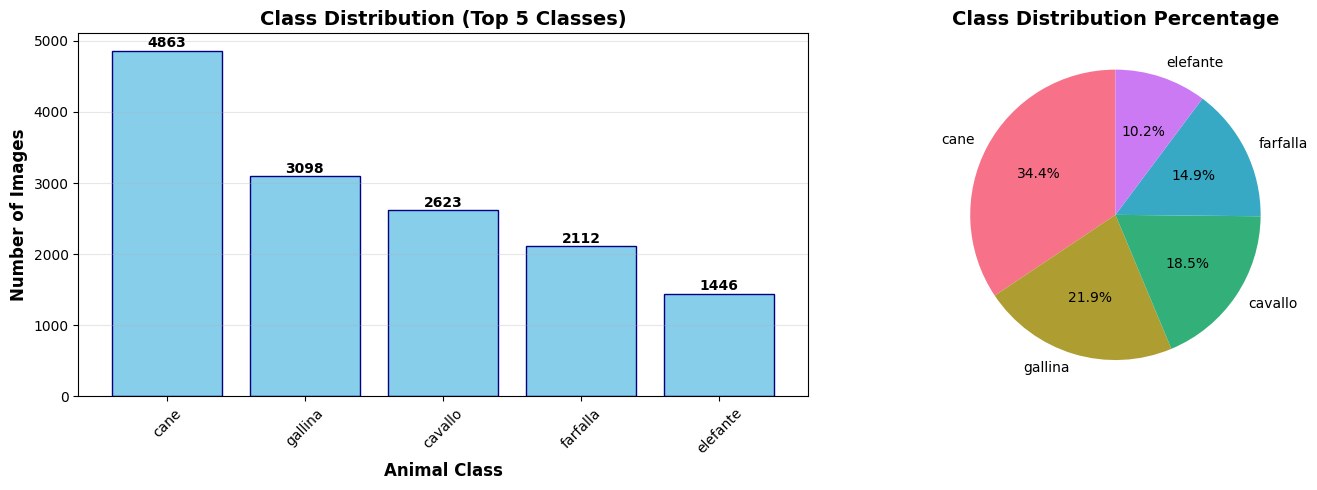

📊 Total images in filtered dataset: 14142


In [8]:
# Visualize Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of class distribution
class_counts_filtered = df_filtered['class'].value_counts()
axes[0].bar(class_counts_filtered.index, class_counts_filtered.values, color='skyblue', edgecolor='navy')
axes[0].set_xlabel('Animal Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution (Top 5 Classes)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (idx, val) in enumerate(class_counts_filtered.items()):
    axes[0].text(i, val + 5, str(val), ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts_filtered.values, labels=class_counts_filtered.index, 
            autopct='%1.1f%%', startangle=90, colors=sns.color_palette("husl", len(class_counts_filtered)))
axes[1].set_title('Class Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"📊 Total images in filtered dataset: {len(df_filtered)}")

In [9]:
# Implement 80/10/10 Data Split with Stratification
print("🔄 Implementing 80/10/10 data split with stratification...")
print("=" * 60)

# Create class-to-index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(top_5_classes))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"🏷️  Class mapping:")
for cls, idx in class_to_idx.items():
    print(f"   {idx}: {cls}")
print("=" * 60)

# Add numeric class labels
df_filtered['class_idx'] = df_filtered['class'].map(class_to_idx)

# First split: 80% train, 20% temp (which will be split into val and test)
train_df, temp_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered['class'],
    random_state=42
)

# Second split: split temp into 50% val, 50% test (10% and 10% of original)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['class'],
    random_state=42
)

print(f"📊 Data Split Summary:")
print(f"   Training set: {len(train_df)} images ({len(train_df)/len(df_filtered)*100:.1f}%)")
print(f"   Validation set: {len(val_df)} images ({len(val_df)/len(df_filtered)*100:.1f}%)")
print(f"   Test set: {len(test_df)} images ({len(test_df)/len(df_filtered)*100:.1f}%)")
print(f"   Total: {len(df_filtered)} images")
print("=" * 60)

# Verify stratification
print("\n📈 Images per class in each split:")
split_summary = pd.DataFrame({
    'Train': train_df['class'].value_counts().sort_index(),
    'Val': val_df['class'].value_counts().sort_index(),
    'Test': test_df['class'].value_counts().sort_index()
})
print(split_summary)
print("=" * 60)

# Verify percentages
print("\n📊 Split percentages per class:")
split_percentages = pd.DataFrame({
    'Train %': (train_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index(),
    'Val %': (val_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index(),
    'Test %': (test_df['class'].value_counts() / df_filtered['class'].value_counts() * 100).sort_index()
})
print(split_percentages.round(1))
print("=" * 60)

print("✅ Data split completed with balanced class distribution!")

🔄 Implementing 80/10/10 data split with stratification...
🏷️  Class mapping:
   0: cane
   1: cavallo
   2: elefante
   3: farfalla
   4: gallina
📊 Data Split Summary:
   Training set: 11313 images (80.0%)
   Validation set: 1414 images (10.0%)
   Test set: 1415 images (10.0%)
   Total: 14142 images

📈 Images per class in each split:
          Train  Val  Test
class                     
cane       3890  486   487
cavallo    2098  262   263
elefante   1157  145   144
farfalla   1690  211   211
gallina    2478  310   310

📊 Split percentages per class:
          Train %  Val %  Test %
class                           
cane         80.0   10.0    10.0
cavallo      80.0   10.0    10.0
elefante     80.0   10.0    10.0
farfalla     80.0   10.0    10.0
gallina      80.0   10.0    10.0
✅ Data split completed with balanced class distribution!


In [10]:
# Create YOLO Directory Structure
print("📁 Creating YOLO directory structure...")
print("=" * 60)

# Define base directory
base_dir = Path('dataset')

# Create directory structure
dirs_to_create = [
    base_dir / 'images' / 'train',
    base_dir / 'images' / 'val',
    base_dir / 'images' / 'test',
    base_dir / 'labels' / 'train',
    base_dir / 'labels' / 'val',
    base_dir / 'labels' / 'test'
]

for dir_path in dirs_to_create:
    dir_path.mkdir(parents=True, exist_ok=True)
    print(f"   ✓ Created: {dir_path}")

print("=" * 60)
print("✅ Directory structure created successfully!")

# Display directory tree
print("\n🌳 Directory Structure:")
print("dataset/")
print("├── images/")
print("│   ├── train/")
print("│   ├── val/")
print("│   └── test/")
print("└── labels/")
print("    ├── train/")
print("    ├── val/")
print("    └── test/")

📁 Creating YOLO directory structure...
   ✓ Created: dataset/images/train
   ✓ Created: dataset/images/val
   ✓ Created: dataset/images/test
   ✓ Created: dataset/labels/train
   ✓ Created: dataset/labels/val
   ✓ Created: dataset/labels/test
✅ Directory structure created successfully!

🌳 Directory Structure:
dataset/
├── images/
│   ├── train/
│   ├── val/
│   └── test/
└── labels/
    ├── train/
    ├── val/
    └── test/


In [11]:
# Copy Images and Create YOLO Format Annotations
print("📋 Copying images and creating YOLO format annotations...")
print("=" * 60)

def create_yolo_annotation(img_path, class_idx, output_path):
    """
    Create YOLO format annotation for an image.
    For this dataset, we'll create a bounding box for the entire image
    since we don't have pre-existing bounding box annotations.
    
    YOLO format: class x_center y_center width height (all normalized 0-1)
    """
    try:
        # Read image to get dimensions
        img = Image.open(img_path)
        img_width, img_height = img.size
        
        # Create bounding box covering the entire image
        # Normalized coordinates: center at 0.5, 0.5, full width and height
        x_center = 0.5
        y_center = 0.5
        width = 1.0
        height = 1.0
        
        # Write YOLO format annotation
        with open(output_path, 'w') as f:
            f.write(f"{class_idx} {x_center} {y_center} {width} {height}\n")
        
        return True
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        return False

def process_split(df, split_name):
    """Process images and create annotations for a specific split."""
    print(f"\n🔄 Processing {split_name} split...")
    
    img_dir = base_dir / 'images' / split_name
    label_dir = base_dir / 'labels' / split_name
    
    success_count = 0
    error_count = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {split_name}"):
        try:
            # Copy image
            src_img = row['path']
            filename = Path(row['filename']).stem
            dst_img = img_dir / f"{filename}.jpg"
            
            # Copy and convert image to RGB if needed
            img = Image.open(src_img).convert('RGB')
            img.save(dst_img, 'JPEG')
            
            # Create YOLO annotation
            label_file = label_dir / f"{filename}.txt"
            if create_yolo_annotation(src_img, row['class_idx'], label_file):
                success_count += 1
            else:
                error_count += 1
                
        except Exception as e:
            print(f"❌ Error processing {row['filename']}: {e}")
            error_count += 1
    
    print(f"   ✅ Successfully processed: {success_count} images")
    if error_count > 0:
        print(f"   ⚠️  Errors: {error_count} images")
    
    return success_count, error_count

# Process each split
train_success, train_errors = process_split(train_df, 'train')
val_success, val_errors = process_split(val_df, 'val')
test_success, test_errors = process_split(test_df, 'test')

print("\n" + "=" * 60)
print("📊 Processing Summary:")
print(f"   Training: {train_success} successful, {train_errors} errors")
print(f"   Validation: {val_success} successful, {val_errors} errors")
print(f"   Test: {test_success} successful, {test_errors} errors")
print(f"   Total: {train_success + val_success + test_success} images processed")
print("=" * 60)
print("✅ Images copied and annotations created successfully!")

📋 Copying images and creating YOLO format annotations...

🔄 Processing train split...


Processing train: 100%|██████████| 11313/11313 [00:12<00:00, 876.98it/s]


   ✅ Successfully processed: 11313 images

🔄 Processing val split...


Processing val: 100%|██████████| 1414/1414 [00:01<00:00, 936.81it/s]


   ✅ Successfully processed: 1414 images

🔄 Processing test split...


Processing test: 100%|██████████| 1415/1415 [00:01<00:00, 939.12it/s]

   ✅ Successfully processed: 1415 images

📊 Processing Summary:
   Training: 11313 successful, 0 errors
   Validation: 1414 successful, 0 errors
   Test: 1415 successful, 0 errors
   Total: 14142 images processed
✅ Images copied and annotations created successfully!


In [12]:
# Generate data.yaml Configuration File
print("📝 Generating data.yaml configuration file...")
print("=" * 60)

# Get absolute paths
abs_base_dir = Path(os.getcwd()) / base_dir

# Create data.yaml configuration
data_yaml = {
    'path': str(abs_base_dir),
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'nc': len(top_5_classes),
    'names': sorted(top_5_classes)
}

# Save data.yaml
yaml_path = base_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print("✅ data.yaml created successfully!")
print("\n📄 Configuration contents:")
print("=" * 60)
with open(yaml_path, 'r') as f:
    print(f.read())
print("=" * 60)

📝 Generating data.yaml configuration file...
✅ data.yaml created successfully!

📄 Configuration contents:
path: /Users/vireakroth/Developer/animal-detection/dataset
train: images/train
val: images/val
test: images/test
nc: 5
names:
- cane
- cavallo
- elefante
- farfalla
- gallina



In [14]:
# Verify Dataset and Print Final Summary
print("✅ PHASE 1 COMPLETE: Environment Setup & Dataset Preparation")
print("=" * 60)

# Count files in each directory
def count_files(directory):
    return len(list(directory.glob('*')))

train_images = count_files(base_dir / 'images' / 'train')
train_labels = count_files(base_dir / 'labels' / 'train')
val_images = count_files(base_dir / 'images' / 'val')
val_labels = count_files(base_dir / 'labels' / 'val')
test_images = count_files(base_dir / 'images' / 'test')
test_labels = count_files(base_dir / 'labels' / 'test')

print("\n📊 FINAL DATASET SUMMARY:")
print("=" * 60)
print(f"Dataset Location: {abs_base_dir}")
print(f"Configuration File: {yaml_path}")
print(f"\nTotal Classes: {len(top_5_classes)}")
print(f"Class Names: {sorted(top_5_classes)}")
print(f"\nData Split (80/10/10):")
print(f"   Training:   {train_images} images, {train_labels} labels")
print(f"   Validation: {val_images} images, {val_labels} labels")
print(f"   Test:       {test_images} images, {test_labels} labels")
print(f"   Total:      {train_images + val_images + test_images} images")

print("\n📈 Images per Class per Split:")
print(split_summary)

print("\n✅ Validation Checks:")
print(f"   ✓ Number of classes: {len(top_5_classes)} (requirement: 5)")
print(f"   ✓ Images match labels in train: {train_images == train_labels}")
print(f"   ✓ Images match labels in val: {val_images == val_labels}")
print(f"   ✓ Images match labels in test: {test_images == test_labels}")
print(f"   ✓ YOLO format annotations: Created")
print(f"   ✓ data.yaml configuration: Created")
print(f"   ✓ Stratified split maintained: Yes")

print("\n🎯 Next Steps:")
print("   → Proceed to Phase 2: Model Configuration & Training")
print("   → Use the data.yaml file for training")
print("   → Dataset is ready for YOLO training!")
print("=" * 60)

✅ PHASE 1 COMPLETE: Environment Setup & Dataset Preparation

📊 FINAL DATASET SUMMARY:
Dataset Location: /Users/vireakroth/Developer/animal-detection/dataset
Configuration File: dataset/data.yaml

Total Classes: 5
Class Names: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina']

Data Split (80/10/10):
   Training:   11313 images, 11313 labels
   Validation: 1414 images, 1414 labels
   Test:       1415 images, 1415 labels
   Total:      14142 images

📈 Images per Class per Split:
          Train  Val  Test
class                     
cane       3890  486   487
cavallo    2098  262   263
elefante   1157  145   144
farfalla   1690  211   211
gallina    2478  310   310

✅ Validation Checks:
   ✓ Number of classes: 5 (requirement: 5)
   ✓ Images match labels in train: True
   ✓ Images match labels in val: True
   ✓ Images match labels in test: True
   ✓ YOLO format annotations: Created
   ✓ data.yaml configuration: Created
   ✓ Stratified split maintained: Yes

🎯 Next Steps:
   → Proceed t

🖼️  Displaying sample images from each class...


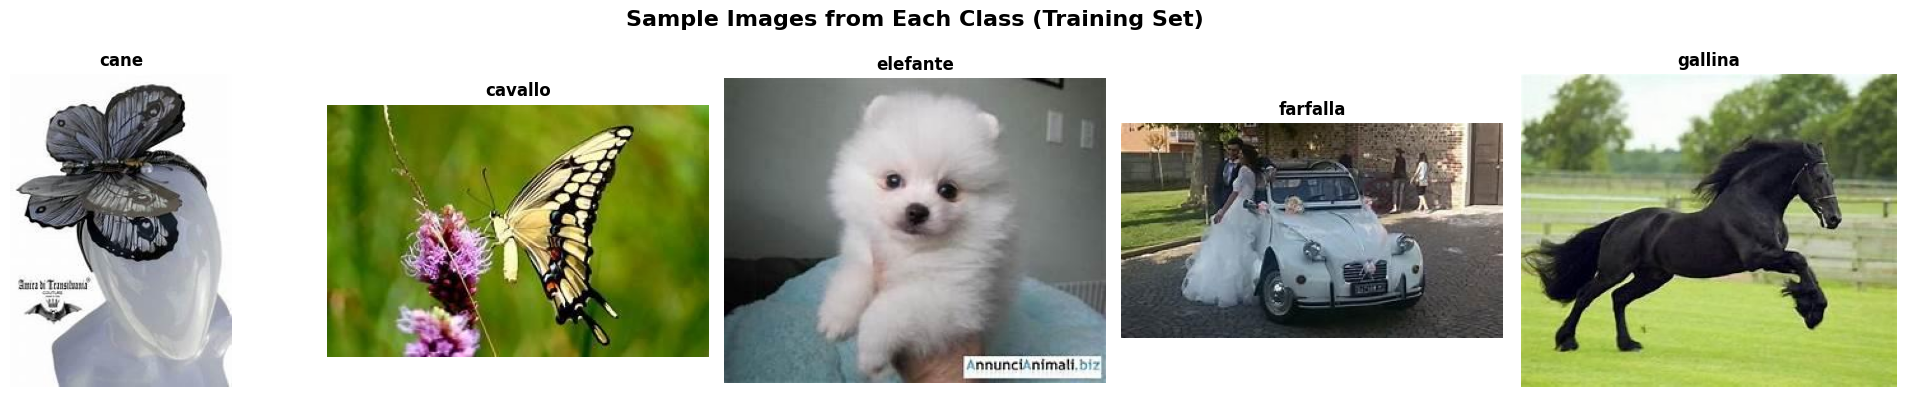

✅ Sample visualization complete!


In [15]:
# Display Sample Images with Annotations
print("🖼️  Displaying sample images from each class...")
print("=" * 60)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Sample Images from Each Class (Training Set)', fontsize=16, fontweight='bold')

for idx, class_name in enumerate(sorted(top_5_classes)):
    # Get a random image from this class
    class_images = list((base_dir / 'images' / 'train').glob('*.jpg'))
    
    if class_images:
        # Read corresponding label to verify class
        sample_img = random.choice(class_images)
        img = cv2.imread(str(sample_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("✅ Sample visualization complete!")